In [1]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint as ci
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from matplotlib.animation import FuncAnimation

In [2]:
import sys
sys.version

'3.9.15 (main, Nov  4 2022, 11:11:31) \n[Clang 12.0.0 ]'

## Basic Data processing function. We achieved visualization of all data or particular departments by user input

In [3]:
def get_clean_cape_dataframe(filepath):
    """
    read the cleaned data as dataframe
    Args:
        filepath: str
        the location of the csv file
    Returns:
        dataframe
    """
    assert isinstance(filepath, str), 'The type of filepath must be string'
    df = pd.read_csv(filepath)
    return df

In [4]:
def get_depts_and_courses_dictionary(df):
    """
    get all courses for departments
    Args:
        df: dataframe

    Returns:
        depths_courses: dict

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_depts_and_courses_dictionary(df)
        depths_courses = {'AAS': ['10', '11', '170', '190'], 'ANAR': ['100', '114', '115', '116', '135', '135S', '143']}

    """
    assert isinstance(df, pd.DataFrame), 'Input type must be dataframe'
    df = (df['Course_ID'].str.split(expand=True)
          .rename(columns={0: 'dept', 1: 'course'})
          .drop_duplicates())

    depts = natsorted(df.dept.unique())
    df = df.set_index(['dept', 'course']).sort_index()

    depts_courses = {dept: natsorted(df.loc[dept].index) for dept in depts}

    return depts_courses

In [5]:
def get_global_avg_time(df):
    """
    return the average time and stand deviation for all courses
    """
    assert isinstance(df, pd.DataFrame), 'Input type must be dataframe'
    gb = df[['Course_ID', 'time']]
    global_average = float(gb.mean())
    global_sd = float(gb.std())
    
    return global_average, global_sd

def get_global_avg_grade(df):
    """
    return the average grade and stand deviation for all courses
    """
    assert isinstance(df, pd.DataFrame), 'Input type must be dataframe'
    gb = df[['Course_ID', 'actual_gpa']]
    global_average = float(gb.mean())
    global_sd = float(gb.std())
    return global_average, global_sd
    
    

In [6]:
df = get_clean_cape_dataframe('data_clean.csv')

In [7]:
df

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",SP23,66,48,93.5,100.0,2.80,AAS 10,Intro/African-American Studies (A),A-,3.84,B+,3.67
1,"Butler, Elizabeth Annette",SP23,20,7,100.0,100.0,2.50,AAS 170,Legacies of Research (A),A-,3.86,A-,3.92
2,"Shtienberg, Gilad",SP23,26,6,100.0,83.3,3.83,ANAR 115,Coastal Geomorphology/Environ (A),B+,3.50,B,3.07
3,"Braswell, Geoffrey E.",SP23,22,9,100.0,100.0,5.17,ANAR 155,Stdy Abrd: Ancient Mesoamerica (A),A,4.00,A,4.00
4,"Hrvoj Mihic, Branka",SP23,22,4,100.0,100.0,2.50,ANBI 111,Human Evolution (A),A,4.00,B-,2.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15400,"Blomstedt, Elizabeth Ann",SP19,20,6,100.0,100.0,4.50,WCWP 100,Academic Writing (B),B+,3.60,B+,3.42
15401,"McCleary, Keith Long",SP19,20,19,84.2,94.4,8.39,WCWP 100,Academic Writing (C),B-,2.95,B,3.17
15402,"Young, Mark T",SP19,20,8,75.0,87.5,8.00,WCWP 100,Academic Writing (F),B,3.13,B+,3.34
15403,"Gagnon, Jeffrey C",SP19,150,126,76.9,91.5,5.21,WCWP 10A,The Writing Course A (0),B,3.11,B,3.21


## Input the weights

Please provide your preferences for each category on a scale of 1 to 10, separated by spaces

(GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

For example, enter: 10 10 5 5 5

In [8]:
user_input = input("Enter ratings separated by spaces: ")
assert len(user_input) != 0, 'Input should not be none'
user_input_splits = user_input.split()

for user_input_split in user_input_splits:
    assert len(user_input_splits) == 5, 'Invalid input weights, there should be 5 weights'
    try:
        int(user_input_split)
    except ValueError:
        'Input weights should be integer or float'

ratings = list(map(int, user_input_splits))

def weights(ratings):
    """
    Calculate weights based on rankings
    
    Args:
        ratings: input ratings
    
    Return:
        list: ration of ratings to sum of all ratings
    """
    assert isinstance(ratings, list), 'Input must be a list.'
    weights = []
    for i in ratings:
        weights.append(i/sum(ratings))
    return weights
        

Enter ratings separated by spaces: 10 10 10 5 5


In [9]:
weights = weights(ratings)
print(weights)

[0.25, 0.25, 0.25, 0.125, 0.125]


## Input the desired quarters

Please input a space seperated list of desired quarters using the corresponding numbers:

1. Fall
2. Winter
3. Spring
4. Summer Session 1
5. Summer Session 2

For example, entering `1 2 3` will select Fall, Winter, and Spring.

In [10]:
# Check if the quarter is valid
input_quarters = input("Enter quarter numbers separated by spaces: ").split()
assert len(input_quarters) != 0, 'Input should not be none'
for input_quarter in input_quarters:
    assert input_quarter.isnumeric(), 'Input is not numeric'
    assert int(input_quarter) < 6 and int(input_quarter) > 0, 'Quarters are out of range'
    
quarters = list(map(int, input_quarters))

print(quarters)

Enter quarter numbers separated by spaces: 2
[2]


## Input the desired depeartments

Please input a space seperated list of desired quarters 
Ex: ECE CSE

In [11]:
# create a dictionary of all departments and courses
all_depts_dict = get_depts_and_courses_dictionary(df)

user_input = input("Enter department names separated by spaces: ")
assert len(user_input) != 0, 'Input should not be none'
depts_input = user_input.split()
depts = []
for dept in depts_input:
    dept = dept.upper()
    assert dept in all_depts_dict, 'The input is not a valid department'
    depts.append(dept)

depts

Enter department names separated by spaces: ece


['ECE']

In [12]:
maps = {1: 'FA', 2:'WI', 3:'SP', 4: 'S1', 5:'S2'}

# maps quarters to string name and slices df based on quarters
quarter_str = '|'.join([maps[q] for q in quarters])
df2 = df[df['term'].str.contains(quarter_str)].reset_index(drop=True)
df2

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",WI23,65,46,93.5,93.3,4.15,AAS 11,Intro Black Diasporic Studies (A),A-,3.84,A-,3.71
1,"Shtienberg, Gilad",WI23,27,9,100.0,100.0,3.61,ANAR 116,Sea Level ChangeIsrael (A),A,4.00,B+,3.62
2,"Braswell, Geoffrey E.",WI23,24,15,100.0,92.9,3.42,ANAR 135,Ancient Mediterranean Civ (A),A,4.00,A-,3.99
3,"Rodriguez, Eric Andrew",WI23,41,23,100.0,100.0,4.07,ANAR 164,Underwater Archaeology (A),A-,3.80,B+,3.63
4,"Non, Amy L",WI23,71,45,84.4,81.8,4.28,ANBI 130,Biology of Inequality (A),B+,3.42,B+,3.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4236,"Cartwright, Lisa",WI20,280,91,82.8,89.7,3.20,VIS 84,History Of Film (A),A-,3.84,A-,3.80
4237,"McCleary, Keith Long",WI20,21,21,81.0,90.5,6.12,WCWP 100,Academic Writing (A),B+,3.43,B+,3.36
4238,"Twohig, Niall Ivan",WI20,20,4,100.0,100.0,9.83,WCWP 100,Academic Writing (I),B+,3.33,B+,3.69
4239,"Gagnon, Jeffrey C",WI20,324,183,72.7,88.5,4.40,WCWP 10A,The Writing Course A (0),B+,3.47,B+,3.32


In [13]:
df_quarter = df2[df2['Course_ID'].str.contains('|'.join(depts))].reset_index(drop=True)
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Baghdadchi, Saharnaz",WI23,156,120,80.7,94.1,8.09,ECE 101,Linear Systems Fundamentals (A),B,3.24,B-,2.75
1,"Le, Hanh-Phuc",WI23,70,54,94.3,96.2,8.31,ECE 102,Intro/Active Circuit Design (A),B,3.08,B,3.04
2,"Lo, Yu-Hwa",WI23,50,24,83.3,75.0,4.75,ECE 103,Fundamntls/Devices & Materials (A),B,3.08,B-,2.89
3,"Lomakin, Vitaliy",WI23,79,31,71.0,70.0,8.82,ECE 107,Electromagnetism (A),B-,2.87,B,3.06
4,"Zeger, Kenneth A.",WI23,123,51,76.0,91.8,7.07,ECE 109,Engineering Probability&Stats (A),B,3.13,B-,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,"Zeger, Kenneth A.",WI20,189,105,76.2,66.3,8.36,ECE 45,Circuits and Systems (A),B-,2.85,B-,2.74
104,"Gilja, Vikash",WI20,94,27,100.0,100.0,5.70,ECE 5,Intro to ECE (A),A-,3.80,B+,3.54
105,"Hall, Drew A.",WI20,83,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,3.75,B+,3.54
106,"Nguyen, Truong Quang",WI20,72,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,3.75,B+,3.54


In [14]:
# Convert rows to numeric
df_quarter['actual_gpa'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce')
df_quarter['rmd_class'] = pd.to_numeric(df_quarter['rmd_class'], errors='coerce')
df_quarter['rmd_instr'] = pd.to_numeric(df_quarter['rmd_instr'], errors='coerce')
df_quarter['time'] = pd.to_numeric(df_quarter['time'], errors='coerce')
df_quarter['gpa_diff'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce') - pd.to_numeric(df_quarter['expected_gpa'], errors='coerce')

# Calculates the percentile of each entry based on other entries in filtered dataframe
df_quarter['actual_gpa_percentile'] = df_quarter['actual_gpa'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['actual_gpa'], x))
df_quarter['rmd_class_percentile'] = df_quarter['rmd_class'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_class'], x))
df_quarter['rmd_instr_percentile'] = df_quarter['rmd_instr'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_instr'], x))
df_quarter['time_percentile'] = df_quarter['time'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['time'], x))
df_quarter['gpa_diff_percentile'] = df_quarter['gpa_diff'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['gpa_diff'], x))


df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile
0,"Baghdadchi, Saharnaz",WI23,156,120,80.7,94.1,8.09,ECE 101,Linear Systems Fundamentals (A),B,3.24,B-,2.75,-0.49,15.277778,32.407407,59.259259,46.296296,8.333333
1,"Le, Hanh-Phuc",WI23,70,54,94.3,96.2,8.31,ECE 102,Intro/Active Circuit Design (A),B,3.08,B,3.04,-0.04,29.629630,69.444444,66.666667,54.166667,60.185185
2,"Lo, Yu-Hwa",WI23,50,24,83.3,75.0,4.75,ECE 103,Fundamntls/Devices & Materials (A),B,3.08,B-,2.89,-0.19,21.759259,37.500000,16.203704,3.703704,43.055556
3,"Lomakin, Vitaliy",WI23,79,31,71.0,70.0,8.82,ECE 107,Electromagnetism (A),B-,2.87,B,3.06,0.19,31.481481,10.185185,12.037037,63.888889,90.740741
4,"Zeger, Kenneth A.",WI23,123,51,76.0,91.8,7.07,ECE 109,Engineering Probability&Stats (A),B,3.13,B-,2.75,-0.38,15.277778,19.444444,49.074074,23.148148,14.814815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,"Zeger, Kenneth A.",WI20,189,105,76.2,66.3,8.36,ECE 45,Circuits and Systems (A),B-,2.85,B-,2.74,-0.11,13.425926,21.296296,9.259259,56.481481,51.388889
104,"Gilja, Vikash",WI20,94,27,100.0,100.0,5.70,ECE 5,Intro to ECE (A),A-,3.80,B+,3.54,-0.26,75.462963,93.518519,90.277778,7.407407,32.407407
105,"Hall, Drew A.",WI20,83,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,3.75,B+,3.54,-0.21,75.462963,93.518519,90.277778,9.722222,40.740741
106,"Nguyen, Truong Quang",WI20,72,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,3.75,B+,3.54,-0.21,75.462963,93.518519,90.277778,9.722222,40.740741


In [15]:
# (GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

df_quarter['rec_score'] = weights[0] * df_quarter['actual_gpa_percentile'] + \
                    weights[1] * df_quarter['time_percentile'] + \
                    weights[2] * df_quarter['gpa_diff_percentile'] + \
                    weights[3] * df_quarter['rmd_class_percentile'] + \
                    weights[4] * df_quarter['rmd_instr_percentile']
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,"Baghdadchi, Saharnaz",WI23,156,120,80.7,94.1,8.09,ECE 101,Linear Systems Fundamentals (A),B,3.24,B-,2.75,-0.49,15.277778,32.407407,59.259259,46.296296,8.333333,28.935185
1,"Le, Hanh-Phuc",WI23,70,54,94.3,96.2,8.31,ECE 102,Intro/Active Circuit Design (A),B,3.08,B,3.04,-0.04,29.629630,69.444444,66.666667,54.166667,60.185185,53.009259
2,"Lo, Yu-Hwa",WI23,50,24,83.3,75.0,4.75,ECE 103,Fundamntls/Devices & Materials (A),B,3.08,B-,2.89,-0.19,21.759259,37.500000,16.203704,3.703704,43.055556,23.842593
3,"Lomakin, Vitaliy",WI23,79,31,71.0,70.0,8.82,ECE 107,Electromagnetism (A),B-,2.87,B,3.06,0.19,31.481481,10.185185,12.037037,63.888889,90.740741,49.305556
4,"Zeger, Kenneth A.",WI23,123,51,76.0,91.8,7.07,ECE 109,Engineering Probability&Stats (A),B,3.13,B-,2.75,-0.38,15.277778,19.444444,49.074074,23.148148,14.814815,21.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,"Zeger, Kenneth A.",WI20,189,105,76.2,66.3,8.36,ECE 45,Circuits and Systems (A),B-,2.85,B-,2.74,-0.11,13.425926,21.296296,9.259259,56.481481,51.388889,34.143519
104,"Gilja, Vikash",WI20,94,27,100.0,100.0,5.70,ECE 5,Intro to ECE (A),A-,3.80,B+,3.54,-0.26,75.462963,93.518519,90.277778,7.407407,32.407407,51.793981
105,"Hall, Drew A.",WI20,83,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,3.75,B+,3.54,-0.21,75.462963,93.518519,90.277778,9.722222,40.740741,54.456019
106,"Nguyen, Truong Quang",WI20,72,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,3.75,B+,3.54,-0.21,75.462963,93.518519,90.277778,9.722222,40.740741,54.456019


In [16]:
# Trunkates the course name to combine sessions of the same class
df_quarter['Course_Name'] = df_quarter['Course_Name'].str[:-3]

In [17]:
# Groups the classes the course_id and sorts based on the calculated recommendation score
df_group = df_quarter.groupby(['Course_ID','Course_Name']).mean().round(2).reset_index()
df_group = df_group.sort_values(by = 'rec_score', ascending = False).reset_index()
df_group

,index,Course_ID,Course_Name,enroll,evals,rmd_class,rmd_instr,time,expected_gpa,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,14,ECE 144,LabVIEW Programming,33.33,24.33,96.43,99.20,10.09,3.48,3.62,0.14,85.34,77.01,84.26,76.23,83.80,81.50
1,18,ECE 157A,Communications Systems Lab I,22.00,10.00,88.90,100.00,9.17,3.50,3.68,0.18,88.89,47.69,90.28,69.44,89.35,79.17
2,19,ECE 16,Rapid Hardware & Software Dsn,29.00,14.00,100.00,92.30,7.50,3.17,3.66,0.49,86.57,93.52,52.31,31.48,98.15,72.28
3,13,ECE 143,Programming for Data Analysis,107.50,73.75,97.40,97.88,7.78,3.86,3.88,0.01,96.99,81.13,75.46,40.97,70.49,71.69
4,15,ECE 148,Intro to Autonomous Vehicles,26.00,15.00,84.60,61.50,11.50,3.79,3.84,0.05,95.37,40.74,8.33,88.89,77.78,71.64
5,25,ECE 191,Engineering Group Design Proj,22.00,6.00,83.30,100.00,9.50,3.50,3.48,-0.02,68.52,37.50,90.28,79.17,66.67,69.56
6,23,ECE 176,Intro Deep Learning & Apps,81.00,29.50,91.85,82.80,8.21,3.64,3.80,0.17,94.68,66.20,28.47,50.00,81.02,68.26
7,10,ECE 134,Electrnc Materls Sci/Integ Cir,24.00,11.50,100.00,100.00,5.86,3.47,3.56,0.09,80.79,93.52,90.28,11.57,79.63,65.97
8,20,ECE 161B,Digital Signal Processing I,40.25,15.75,96.68,100.00,7.96,3.18,3.24,0.06,50.46,79.28,90.28,42.82,74.19,63.06
9,6,ECE 111,Advanced Digital Design Proj,136.25,70.00,93.32,94.62,6.87,3.65,3.66,0.01,85.30,65.05,68.06,22.45,68.29,60.65


In [18]:
counts =df_quarter['instr'].value_counts()
# df_group = df_group.sort_values(by = 'rec_score', ascending = False).reset_index()
df_instructor=counts[counts>1].index.tolist()
df_instructor=df_quarter[df_quarter['instr'].isin(df_instructor)]
df_instructor.sort_values(by='instr').reset_index()


,index,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,...,expected_gpa,actual_grade,actual_gpa,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,86,"Abi Samra, Nicholas Camill",WI20,33,12,91.7,91.7,4.50,ECE 128B,Power Grid Modernization,...,3.58,B+,3.55,-0.03,79.166667,56.944444,48.148148,1.851852,62.037037,48.900463
1,59,"Abi Samra, Nicholas Camill",WI21,34,13,100.0,100.0,4.68,ECE 128B,Power Grid Modernization,...,3.75,A-,3.78,0.03,93.518519,93.518519,90.277778,2.777778,75.000000,65.798611
2,33,"Abi Samra, Nicholas Camill",WI22,60,36,100.0,100.0,6.09,ECE 128B,Power Grid Modernization,...,3.54,B+,3.66,0.12,86.574074,93.518519,90.277778,14.814815,86.111111,69.849537
3,0,"Baghdadchi, Saharnaz",WI23,156,120,80.7,94.1,8.09,ECE 101,Linear Systems Fundamentals,...,3.24,B-,2.75,-0.49,15.277778,32.407407,59.259259,46.296296,8.333333,28.935185
4,77,"Baghdadchi, Saharnaz",WI21,165,131,98.5,99.2,8.25,ECE 65,Components & Circuits Lab,...,3.64,B,3.25,-0.39,52.314815,85.185185,79.629630,50.000000,13.888889,49.652778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,71,"Wang, Xiaolong",WI21,50,13,100.0,84.6,7.88,ECE 176,Intro Deep Learning & Apps,...,3.57,A-,3.92,0.35,99.074074,93.518519,31.481481,40.740741,95.370370,74.421296
89,4,"Zeger, Kenneth A.",WI23,123,51,76.0,91.8,7.07,ECE 109,Engineering Probability&Stats,...,3.13,B-,2.75,-0.38,15.277778,19.444444,49.074074,23.148148,14.814815,21.875000
90,103,"Zeger, Kenneth A.",WI20,189,105,76.2,66.3,8.36,ECE 45,Circuits and Systems,...,2.85,B-,2.74,-0.11,13.425926,21.296296,9.259259,56.481481,51.388889,34.143519
91,29,"Zeger, Kenneth A.",WI22,126,38,72.2,75.0,7.67,ECE 109,Engineering Probability&Stats,...,2.86,C+,2.52,-0.34,4.629630,13.888889,16.203704,35.185185,23.611111,19.618056


In [19]:
df_S1 = df[df['term'].str.contains('S1')].reset_index(drop=True)
df_S2 = df[df['term'].str.contains('S2')].reset_index(drop=True)
df_FA = df[df['term'].str.contains('FA')].reset_index(drop=True)
df_WI = df[df['term'].str.contains('WI')].reset_index(drop=True)
df_SP = df[df['term'].str.contains('SP')].reset_index(drop=True)


In [20]:
global_average_S1, global_std_S1 = get_global_avg_time(df_S1)
global_average_S2, global_std_S2 = get_global_avg_time(df_S2)
global_average_FA, global_std_FA = get_global_avg_time(df_FA)
global_average_WI, global_std_WI = get_global_avg_time(df_WI)
global_average_SP, global_std_SP = get_global_avg_time(df_SP)
temp_data={'Quarter':['Summer session 1','Summer session 2','Fall','Winter','Spring'],
           'Average time spent':[global_average_S1,global_average_S2,global_average_FA,global_average_WI,global_average_SP],
           'Standard deviation of time spent':[global_std_S1,global_std_S2,global_std_FA,global_std_WI,global_std_SP]
    
}
time_dif_of_summer=pd.DataFrame(temp_data)
time_dif_of_summer
# global_average_S1,global_average_S2,global_average_WI


# time_factor = get_time_df(df_S1, global_average, global_std)
# time_factor_depart = time_factor[time_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
# print(time_factor_depart)

/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_29097/801811626.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_average = float(gb.mean())
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_29097/801811626.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_sd = float(gb.std())
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_29097/801811626.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_average = float(gb.mean())
/var/folders/

,Quarter,Average time spent,Standard deviation of time spent
0,Summer session 1,6.880363,2.436270
1,Summer session 2,6.876703,2.562852
2,Fall,5.814299,2.264603
3,Winter,5.786296,2.318146
4,Spring,5.797604,2.357134


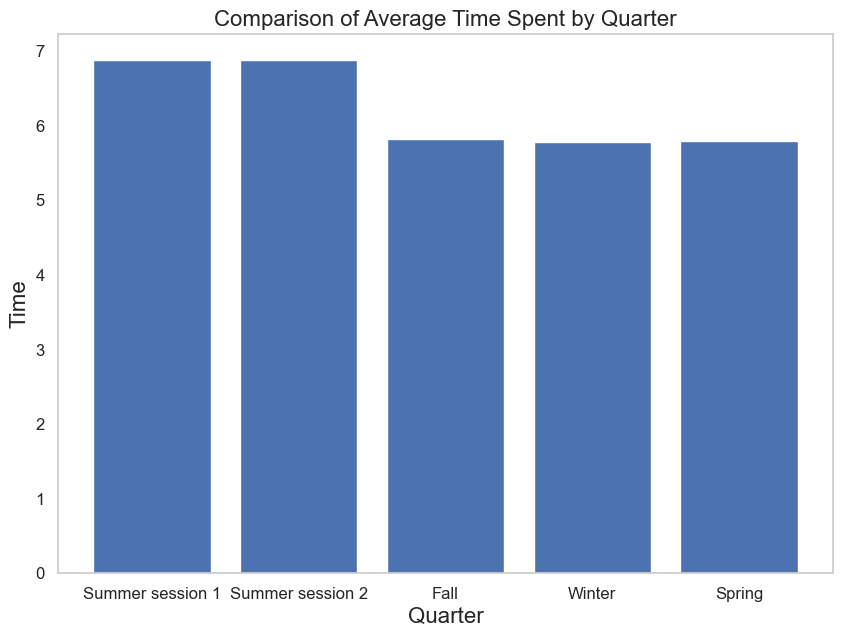

In [21]:
sns.set(style="whitegrid") 

plt.figure(figsize=(10, 7))
# sns.barplot(x='Quarter', y='Data_1', data=df, color='blue', label='Data 1')
# sns.barplot(x='X_values', y='Data_2', data=df, color='orange', label='Data 2')
quarters = time_dif_of_summer['Quarter']
avg_time_spent = time_dif_of_summer['Average time spent']
std_dev_time_spent = time_dif_of_summer['Standard deviation of time spent']

plt.bar(quarters, avg_time_spent, label='Average time spent')


# plt.bar(quarters, std_dev_time_spent, bottom=avg_time_spent, label='Standard deviation of time spent')


plt.xlabel('Quarter',fontsize=16)
plt.ylabel('Time',fontsize=16)
plt.title('Comparison of Average Time Spent by Quarter',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.legend()
plt.grid(False)



In [22]:
Gglobal_average_S1, Gglobal_std_S1 = get_global_avg_grade(df_S1)
Gglobal_average_S2, Gglobal_std_S2 = get_global_avg_grade(df_S2)
Gglobal_average_FA, Gglobal_std_FA = get_global_avg_grade(df_FA)
Gglobal_average_WI, Gglobal_std_WI = get_global_avg_grade(df_WI)
Gglobal_average_SP, Gglobal_std_SP = get_global_avg_grade(df_SP)
temp_data_2={'Quarter':['Summer session 1','Summer session 2','Fall','Winter','Spring'],
           'Average Acutal GPA':[Gglobal_average_S1,Gglobal_average_S2,Gglobal_average_FA,Gglobal_average_WI,Gglobal_average_SP],
           'Standard Deviation of Actual GPA':[Gglobal_std_S1,Gglobal_std_S2,Gglobal_std_FA,Gglobal_std_WI,Gglobal_std_SP]
    
}
GPA_dif_of_summer=pd.DataFrame(temp_data_2)
GPA_dif_of_summer
# global_average_S1,global_average_S2,global_average_WI


# time_factor = get_time_df(df_S1, global_average, global_std)
# time_factor_depart = time_factor[time_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True

/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_29097/801811626.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_average = float(gb.mean())
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_29097/801811626.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_sd = float(gb.std())
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_29097/801811626.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_average = float(gb.mean())
/var/folde

,Quarter,Average Acutal GPA,Standard Deviation of Actual GPA
0,Summer session 1,3.328183,0.404208
1,Summer session 2,3.324796,0.409667
2,Fall,3.343479,0.403809
3,Winter,3.399484,0.391423
4,Spring,3.439003,0.389045


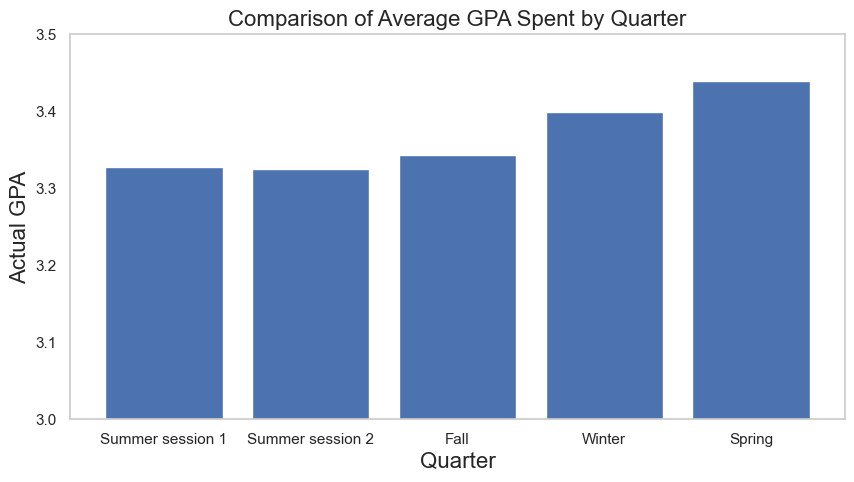

In [23]:
sns.set(style="whitegrid") 

plt.figure(figsize=(10, 5))
# sns.barplot(x='Quarter', y='Data_1', data=df, color='blue', label='Data 1')
# sns.barplot(x='X_values', y='Data_2', data=df, color='orange', label='Data 2')
quarters = GPA_dif_of_summer['Quarter']
avg_gpa = GPA_dif_of_summer['Average Acutal GPA']
std_dev_gpa = GPA_dif_of_summer['Standard Deviation of Actual GPA']

plt.bar(quarters, avg_gpa, label='Average Actual GPA')


# plt.bar(quarters, std_dev_gpa, bottom=avg_gpa, label='Standard Deviation of Actual GPA')
plt.ylim(0,4)

plt.xlabel('Quarter',fontsize=16)
plt.ylabel('Actual GPA',fontsize=16)
plt.title('Comparison of Average GPA Spent by Quarter',fontsize=16)
plt.ylim(3, 3.5)
# plt.legend()
plt.grid(False)
# index = range(len(quarters))



In [24]:
df_ECE143 = df[df['Course_ID'].str.contains('ECE 143')].reset_index(drop=True)
term_order = ['WI19','SP19','FA19', 'WI20', 'SP20', 'FA20', 'WI21', 'SP21', 'FA21', 'WI22', 'SP22', 'FA22', 'WI23', 'SP23', 'FA23']  # 自定义排序顺序
df_ECE143['term'] = pd.Categorical(df_ECE143['term'], categories=term_order, ordered=True)

One_Grade_Trend={
    
}
df_ECE143.sort_values(by='term').reset_index(drop=True)

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Unpingco, Jose H.",SP19,100,58,100.0,100.0,6.46,ECE 143,Programming for Data Analysis (A),A-,3.89,A-,3.80
1,"Unpingco, Jose H.",FA19,101,81,91.3,92.5,7.64,ECE 143,Programming for Data Analysis (A),A-,3.84,A-,3.88
2,"Unpingco, Jose H.",WI20,96,73,98.6,98.6,6.34,ECE 143,Programming for Data Analysis (A),A-,3.96,A-,3.94
3,"Unpingco, Jose H.",FA20,93,62,96.7,98.3,7.52,ECE 143,Programming for Data Analysis (A),A-,3.88,A-,3.86
4,"Unpingco, Jose H.",WI21,140,97,95.8,94.8,9.42,ECE 143,Programming for Data Analysis (A),A-,3.79,A-,3.87
5,"Unpingco, Jose H.",FA21,98,68,92.6,97.1,7.79,ECE 143,Programming for Data Analysis (A),A-,3.82,A-,3.90
6,"Unpingco, Jose H.",WI22,98,68,97.1,100.0,7.88,ECE 143,Programming for Data Analysis (A),A-,3.91,A-,3.88
7,"Unpingco, Jose H.",FA22,100,64,100.0,98.4,6.79,ECE 143,Programming for Data Analysis (A),A-,3.89,A-,3.85
8,"Unpingco, Jose H.",WI23,96,57,98.1,98.1,7.50,ECE 143,Programming for Data Analysis (A),A-,3.80,A-,3.82


/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_29097/3999313716.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 85)` for the same effect.

  sns.lineplot(x='term', y='expected_gpa', data=df_ECE143, marker='o',ci=85,label='Expected GPA')
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_29097/3999313716.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 85)` for the same effect.

  sns.lineplot(x='term', y='actual_gpa', data=df_ECE143, marker='o',ci=85,label='Actual GPA')


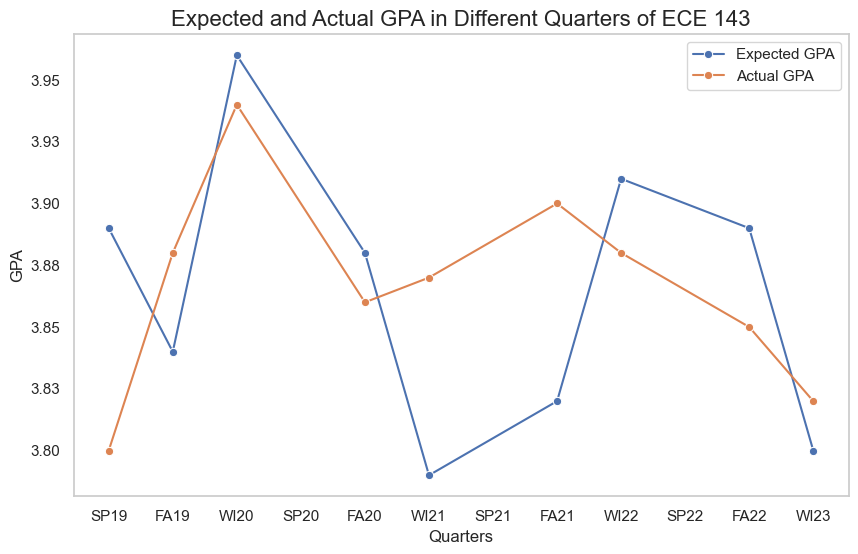

In [25]:
sns.set(style="whitegrid")  
plt.figure(figsize=(10, 6))  

sns.lineplot(x='term', y='expected_gpa', data=df_ECE143, marker='o',ci=85,label='Expected GPA')
sns.lineplot(x='term', y='actual_gpa', data=df_ECE143, marker='o',ci=85,label='Actual GPA')




plt.title('Expected and Actual GPA in Different Quarters of ECE 143',fontsize=16)
plt.xlabel('Quarters')
plt.ylabel('GPA')
plt.grid(False)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))


plt.show()

In [26]:
average_gpa_per_term = df.groupby('term')['expected_gpa','actual_gpa'].mean().reset_index()
average_gpa_per_term

/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_29097/2804434765.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_gpa_per_term = df.groupby('term')['expected_gpa','actual_gpa'].mean().reset_index()


,term,expected_gpa,actual_gpa
0,FA19,3.430651,3.272104
1,FA20,3.533137,3.399841
2,FA21,3.505387,3.323569
3,FA22,3.522990,3.373974
4,S119,3.460472,3.262123
5,S120,3.544194,3.427204
6,S121,3.479676,3.260040
7,S122,3.528933,3.342444
8,S219,3.479453,3.241592
9,S220,3.518226,3.389476


In [27]:
term_order = ['WI19','SP19','FA19', 'WI20', 'SP20', 'FA20', 'WI21', 'SP21', 'FA21', 'WI22', 'SP22', 'FA22', 'WI23', 'SP23', 'FA23']  # 自定义排序顺序
average_gpa_per_term['term'] = pd.Categorical(average_gpa_per_term['term'], categories=term_order, ordered=True)
average_gpa_per_term = average_gpa_per_term.dropna()
average_gpa_per_term.sort_values(by='term').reset_index(drop=True)

,term,expected_gpa,actual_gpa
0,SP19,3.451420,3.302901
1,FA19,3.430651,3.272104
2,WI20,3.453504,3.395102
3,SP20,3.613234,3.671831
4,FA20,3.533137,3.399841
5,WI21,3.561732,3.482647
6,SP21,3.587296,3.472938
7,FA21,3.505387,3.323569
8,WI22,3.516613,3.354723
9,SP22,3.519217,3.350230


/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_29097/1774821618.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 85)` for the same effect.

  sns.lineplot(x='term', y='expected_gpa', data=average_gpa_per_term, marker='o',ci=85,label='Expected GPA')
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_29097/1774821618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 85)` for the same effect.

  sns.lineplot(x='term', y='actual_gpa', data=average_gpa_per_term, marker='o',ci=85,label='Actual GPA')


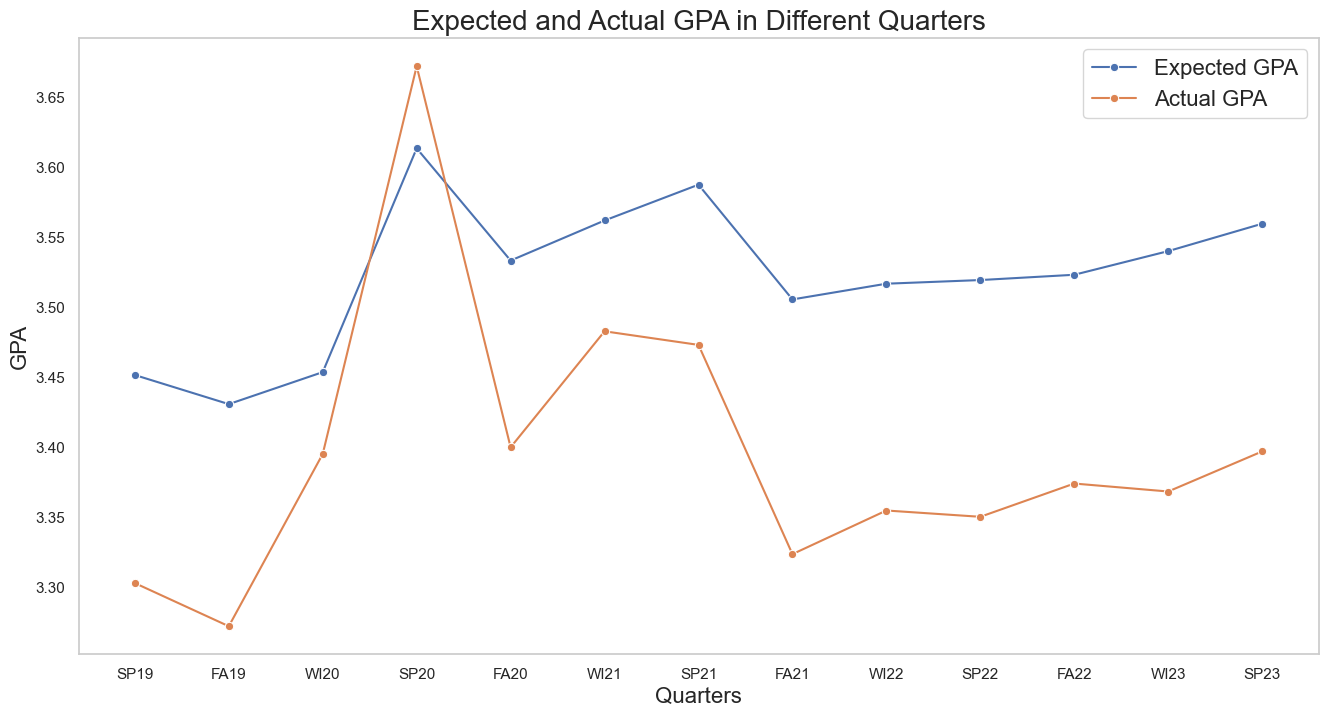

In [28]:
sns.set(style="whitegrid")  
plt.figure(figsize=(16, 8))  

sns.lineplot(x='term', y='expected_gpa', data=average_gpa_per_term, marker='o',ci=85,label='Expected GPA')
sns.lineplot(x='term', y='actual_gpa', data=average_gpa_per_term, marker='o',ci=85,label='Actual GPA')




plt.title('Expected and Actual GPA in Different Quarters',fontsize=20)
plt.xlabel('Quarters',fontsize=16)
plt.ylabel('GPA',fontsize=16)
plt.grid(False)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.legend(fontsize=16)

plt.show()

In [29]:
# Group courses under ECE department by upper division
ece_depths = {
    "Computer Systems": ["ECE 102", "ECE 103","ECE 111", "ECE 140A","ECE 140B", "ECE 141A","ECE 141B", "ECE 143", "ECE 158A","ECE 158B","ECE 165"], 
    "Communication Systems" : ["ECE 153", "ECE 155", "ECE 157A", "ECE 158A","ECE 159"] ,
    "Circuits" : ["ECE 164", "ECE 165", "ECE 166"],
     "Electronic Devices": ["ECE 135A", "ECE 135B", "ECE 136L","ECE 183"] ,
     "Machine Learning/Controls": ["ECE 171A", "ECE 174", "ECE 175A","ECE 171B", "ECE 172A", "ECE 175B"] ,
    "Photonics": ["ECE 181", "ECE 182", "ECE 183","ECE 184","ECE 185"] ,
     "Power": ["ECE 121A", "ECE 121B", "ECE 125A","ECE 128A","ECE 125B","ECE 128B"],
      "Signal/Image Processing": ["ECE 153", "ECE 161A", "ECE 161B","ECE 161C"],
    "Breadth": ["ECE 100","ECE 101","ECE 102","ECE 103","ECE 107","ECE 109"]
}

def calc_new_col(row):
    """
    Calculate the new columns for multiple depth
    
    Args:
        row
    Returns:
        multi_depths
    """
    multi_depths = []
    for k in ece_depths:
        if row["Course_ID"] in ece_depths[k]:
            multi_depths.append(k)
    return multi_depths

df_quarter["ECE Depth"] = df_quarter.apply(calc_new_col, axis=1)
df_quarter = df_quarter.explode("ECE Depth")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


df_depth = df_quarter.groupby("ECE Depth")


def weighted(x, cols, w="enroll"):
    """
    return the weight for each division
    Args:
        x, cols

    Returns:
        pd.Series
    """
    return pd.Series(np.average(x[cols], weights=x[w], axis=0), cols)



Text(0.5, 0, 'Percentage')

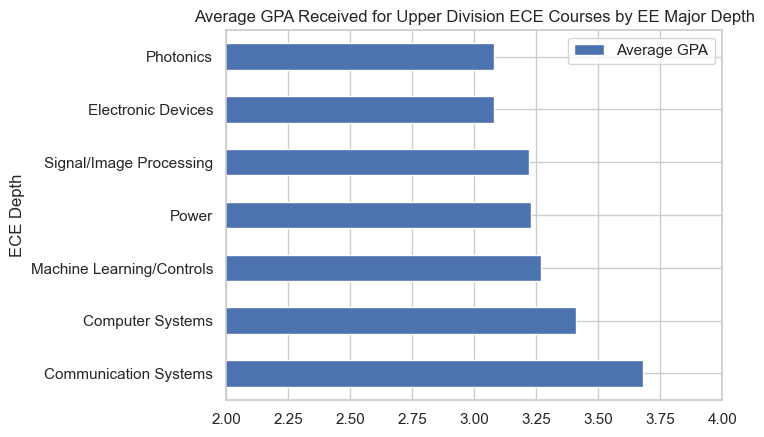

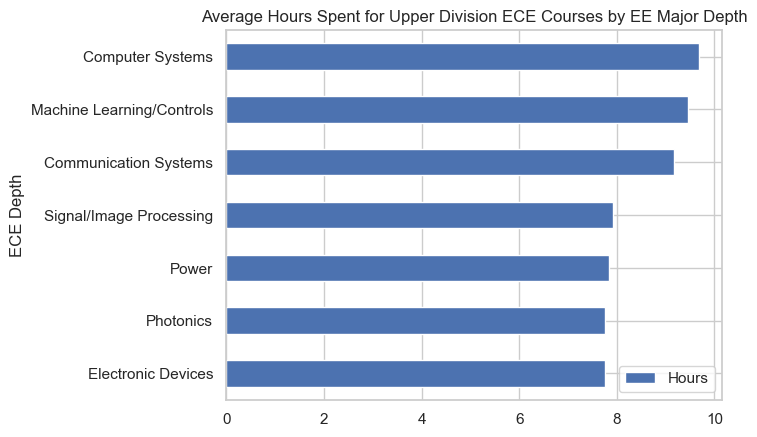

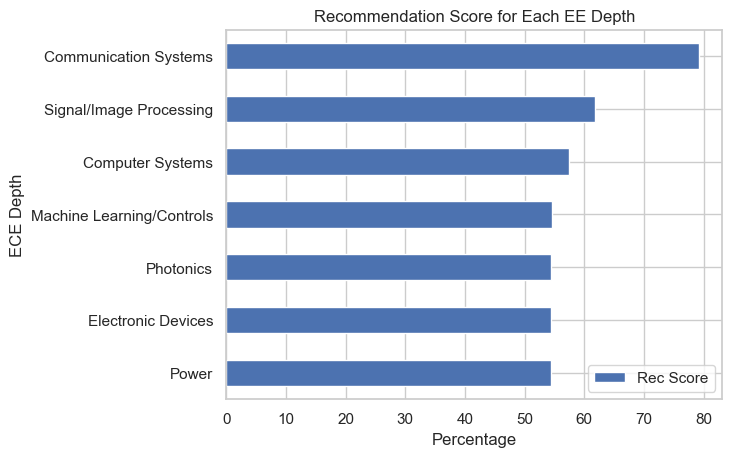

In [30]:
df_depth = df_depth.apply(weighted, ["rmd_class","rmd_instr","time","expected_gpa","actual_gpa","gpa_diff","rec_score"]).round(2)
df_depth = df_depth.sort_values("actual_gpa",ascending=False)
df_depth


# average gpa
df_depth_plot = df_depth.drop("Breadth")
df_depth_plot.plot(y="actual_gpa",kind="barh",title="Average GPA Received for Upper Division ECE Courses by EE Major Depth",xlim=(2.0,4.0))
plt.legend(labels=["Average GPA"])


# average time
df_depth_plot = df_depth_plot.sort_values("time",ascending=True)
df_depth_plot.plot(y="time",kind="barh",title="Average Hours Spent for Upper Division ECE Courses by EE Major Depth")
plt.legend(labels=["Hours"])


# recommendation score
df_depth_plot = df_depth_plot.sort_values("rec_score",ascending=True)
df_depth_plot.plot(y="rec_score",kind="barh",title="Recommendation Score for Each EE Depth")
plt.legend(labels=["Rec Score"])
plt.xlabel("Percentage")

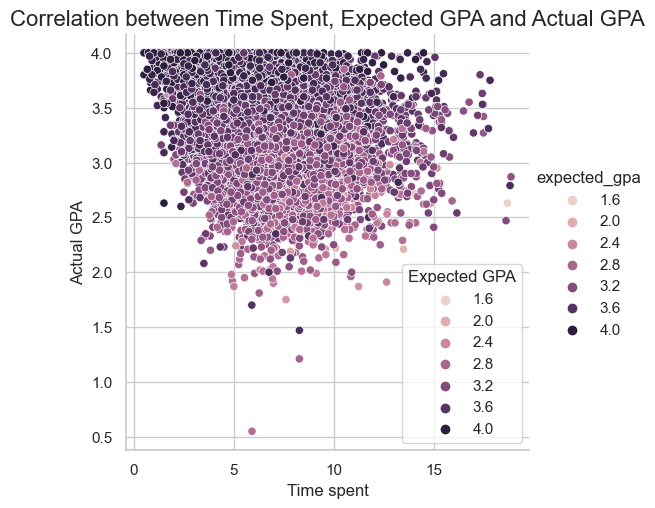

In [31]:
sns.relplot(x='time',y='actual_gpa',hue='expected_gpa',data=df)
plt.title('Correlation between Time Spent, Expected GPA and Actual GPA',fontsize=16)
plt.xlabel('Time spent')
plt.ylabel('Actual GPA')
plt.legend(title='Expected GPA')

# plt.legend(title='Expected GPA')


<Figure size 1600x500 with 0 Axes>

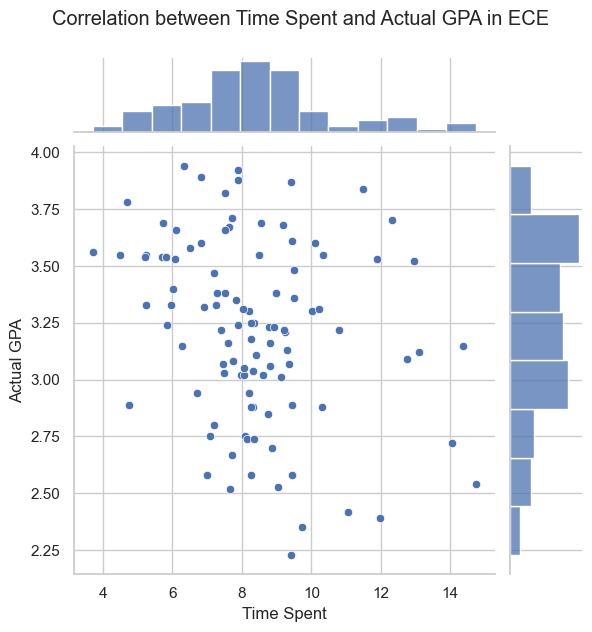

In [32]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='time', y='actual_gpa', data=df_quarter)


joint.set_axis_labels('Time Spent', 'Actual GPA')


joint.fig.suptitle('Correlation between Time Spent and Actual GPA in ECE', y=1.05)
plt.show()

In [33]:
df_below= df[df['rmd_class'] <85]

<Figure size 1600x500 with 0 Axes>

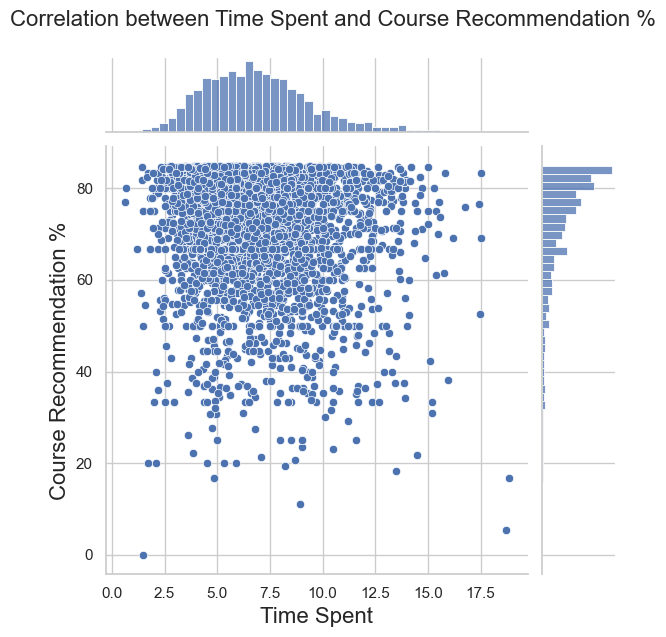

In [34]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='time', y='rmd_class', data=df_below)


joint.set_axis_labels('Time Spent', 'Course Recommendation %',fontsize=16)


joint.fig.suptitle('Correlation between Time Spent and Course Recommendation %', y=1.05,fontsize=16)
plt.show()

<Figure size 1600x500 with 0 Axes>

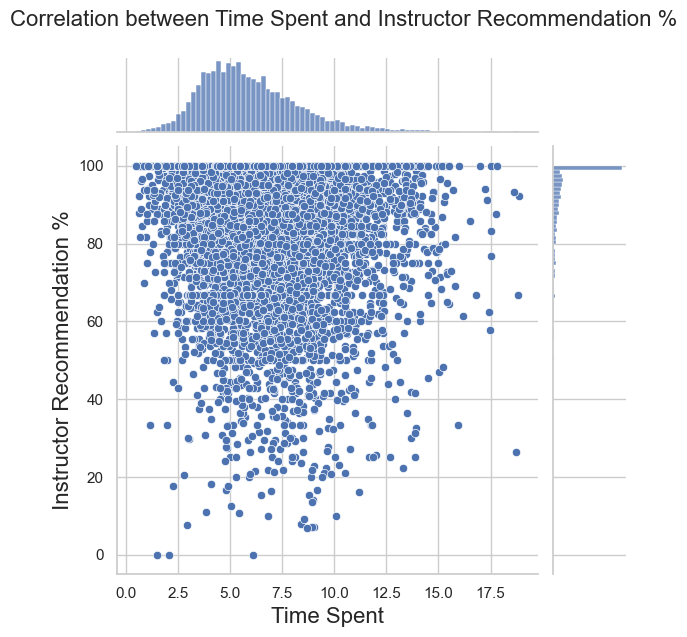

In [35]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='time', y='rmd_instr', data=df)

joint.set_axis_labels('Time Spent', 'Instructor Recommendation %',fontsize=16)

joint.fig.suptitle('Correlation between Time Spent and Instructor Recommendation %', y=1.05,fontsize=16)
plt.show()

<Figure size 1600x500 with 0 Axes>

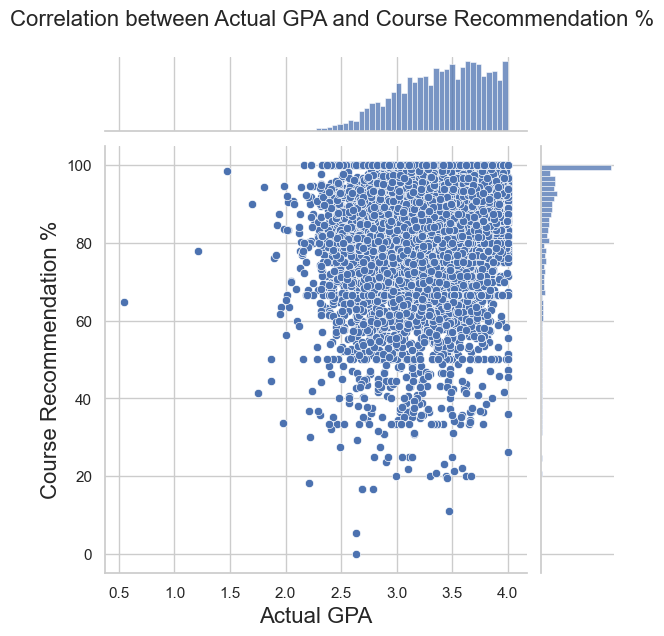

In [36]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='actual_gpa', y='rmd_class', data=df)

joint.set_axis_labels('Actual GPA', 'Course Recommendation %',fontsize=16)

joint.fig.suptitle('Correlation between Actual GPA and Course Recommendation %', y=1.05,fontsize=16)
plt.show()

<Figure size 1600x500 with 0 Axes>

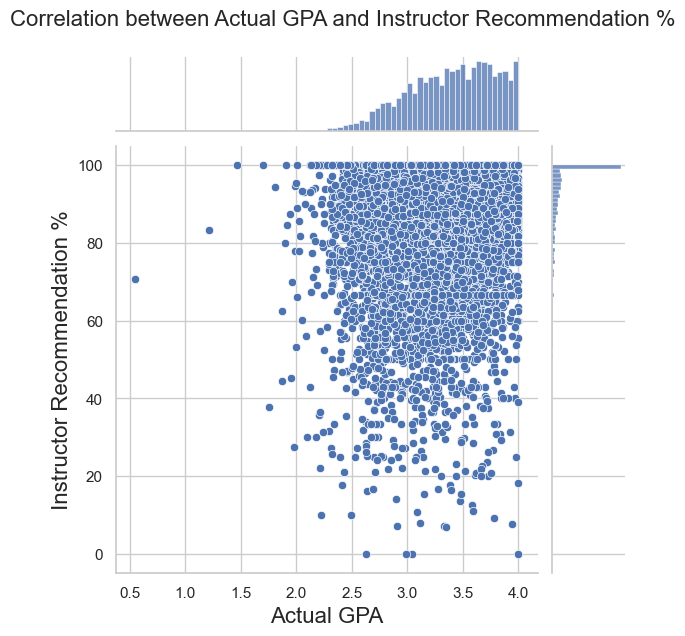

In [37]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='actual_gpa', y='rmd_instr', data=df)

joint.set_axis_labels('Actual GPA', 'Instructor Recommendation %',fontsize=16)

joint.fig.suptitle('Correlation between Actual GPA and Instructor Recommendation %', y=1.05,fontsize=16)
plt.show()